In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)


Python version
3.10.1 | packaged by conda-forge | (main, Dec 22 2021, 01:39:05) [GCC 9.4.0]
Version info.
sys.version_info(major=3, minor=10, micro=1, releaselevel='final', serial=0)


In [1]:
import numpy as np
import cfgrib
import xarray as xr
import matplotlib.pyplot as plt
import cProfile
import pstats
import io
import time
from pstats import SortKey
import dask

In [2]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(queue='postproc', cores=2, memory='24GB')

/users/cosuna/miniconda3_python3.7/envs/postproc_np_products/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
scheduler='threads'
if scheduler=='distributed':
    from dask.distributed import Client
    client = Client(cluster)
    client
elif scheduler=='threads':
    from dask.distributed import Client
    #client = Client(processes=False)
    dask.config.set(scheduler='threads')
    #dask.config.set(pool=ThreadPool(20))
elif scheduler=='synchronous':
    dask.config.set(scheduler='synchronous')  # overwrite default with single-threaded scheduler
elif scheduler=='mpi':
    from dask.distributed import Client
    client = Client(scheduler_file='/users/cosuna/dask-scheduler.json', dashboard_address="localhost:9955")
    

In [3]:

pr = cProfile.Profile()
pr.enable()

pc_g = 9.80665

def destagger(u, du):
    du[1:-1, :] += u[2:, :] + u[0:-2, :]


def level_range(index, short_name):
    levels = index.subindex(
        filter_by_keys={'shortName': short_name, 'typeOfLevel': 'generalVerticalLayer'}).header_values['level:float']

    return (min(levels), max(levels))


def fthetav(p, t, qv):
    pc_r_d = 287.05
    pc_r_v = 461.51  # Gas constant for water vapour[J kg-1 K-1]
    pc_cp_d = 1005.0
    pc_rvd = pc_r_v / pc_r_d

    pc_rdocp = pc_r_d/pc_cp_d
    pc_rvd_o = pc_rvd - 1.0

    # Reference surface pressure for computation of potential temperature
    p0 = 1.0e5
    return (p0 / p) ** pc_rdocp * t * (1.+(pc_rvd_o*qv / (1.-qv)))

def fbrn(p,t,qv,u,v,hhl,hsurf):
    thetav = fthetav(p,t,qv)
    thetav_sum = thetav.isel(generalVerticalLayer=slice(None, None, -1)).cumsum(dim='generalVerticalLayer') 

    # dask.delayed(thetav_sum.data).visualize(filename='thetasum.svg')

    nlevels_xr =xr.DataArray(data=np.arange(nlevels,0,-1), dims=["generalVerticalLayer"])

    brn = pc_g* (hhl-hsurf)*(thetav - thetav.isel(generalVerticalLayer=79)) / \
        ( (thetav_sum/nlevels_xr)*(u**2 + v**2))
    return brn


In [5]:
def load_data(fields, chunk_size=10):
    
    chunk_arg = {}
    if chunk_size:
        chunk_arg = {"chunks": {"generalVerticalLayer": chunk_size}}

    dss = cfgrib.open_datasets(
        data_dir + "/lfff00000000",
        backend_kwargs={
            "read_keys": ["typeOfLevel", "gridType"],
            "filter_by_keys": {"typeOfLevel": "generalVerticalLayer"},
        },
        encode_cf=("time", "geography", "vertical"),
        **chunk_arg
    )

    massds = dss[0]
    uds = cfgrib.open_dataset(
        data_dir + "/lfff00000000",
        backend_kwargs={
            "read_keys": ["cfVarName"],
            "filter_by_keys": {"cfVarName": "u"},
        },
        encode_cf=("time", "geography", "vertical"),
        **chunk_arg
    )

    vds = cfgrib.open_dataset(
        data_dir + "/lfff00000000",
        backend_kwargs={
            "read_keys": ["cfVarName"],
            "filter_by_keys": {"cfVarName": "v"},
        },
        encode_cf=("time", "geography", "vertical"),
        **chunk_arg
    )

    hsurf_ds = cfgrib.open_dataset(
        data_dir + "/lfff00000000c",
        backend_kwargs={
            "read_keys": ["shortName"],
            "filter_by_keys": {"shortName": "HSURF"},
        },
        encode_cf=("time", "geography", "vertical"),
        **chunk_arg
    )

    if chunk_size:
        chunk_arg = {"chunks": {"generalVertical": chunk_size}}

    cds = cfgrib.open_dataset(
        data_dir + "/lfff00000000c",
        backend_kwargs={
            "read_keys": ["typeOfLevel", "gridType"],
            "filter_by_keys": {"typeOfLevel": "generalVertical"},
        },
        encode_cf=("time", "geography", "vertical"),
        **chunk_arg
    )

    hhl = cds["HHL"].rename({"generalVertical": "generalVerticalLayer"})

    return (
        massds["P"],
        massds["T"],
        massds["QV"],
        hhl,
        hsurf_ds["HSURF"],
        uds["U"],
        vds["V"],
    )

In [4]:
data_dir ='/scratch/cosuna/postproc_np_products/grib_files/cosmo-1e/'

start = time.time()
index = cfgrib.open_fileindex(
        data_dir+'/lfff00000000', index_keys=cfgrib.dataset.INDEX_KEYS + ["time", "step"]+["shortName", "paramId"])
levels = level_range(index, 'T')



Ignoring index file '/scratch/cosuna/postproc_np_products/grib_files/cosmo-1e//lfff00000000.02ccc.idx' incompatible with GRIB file


In [235]:
start=time.time()
nlevels = int(levels[1]) - int(levels[0])+1
p,t,qv,hhl,hsurf,u,v = load_data(['P','T','QV','HHL','HSURF','U','V'], chunk_size=10)
end=time.time()
print("time:", end-start)

time: 9.801622152328491


In [236]:
start=time.time()
brn = fbrn(p,t,qv,u,v,hhl,hsurf)
brn.name = "BRN"
end=time.time()
print("Time:", end-start)

Time: 0.486635684967041


# Visualization

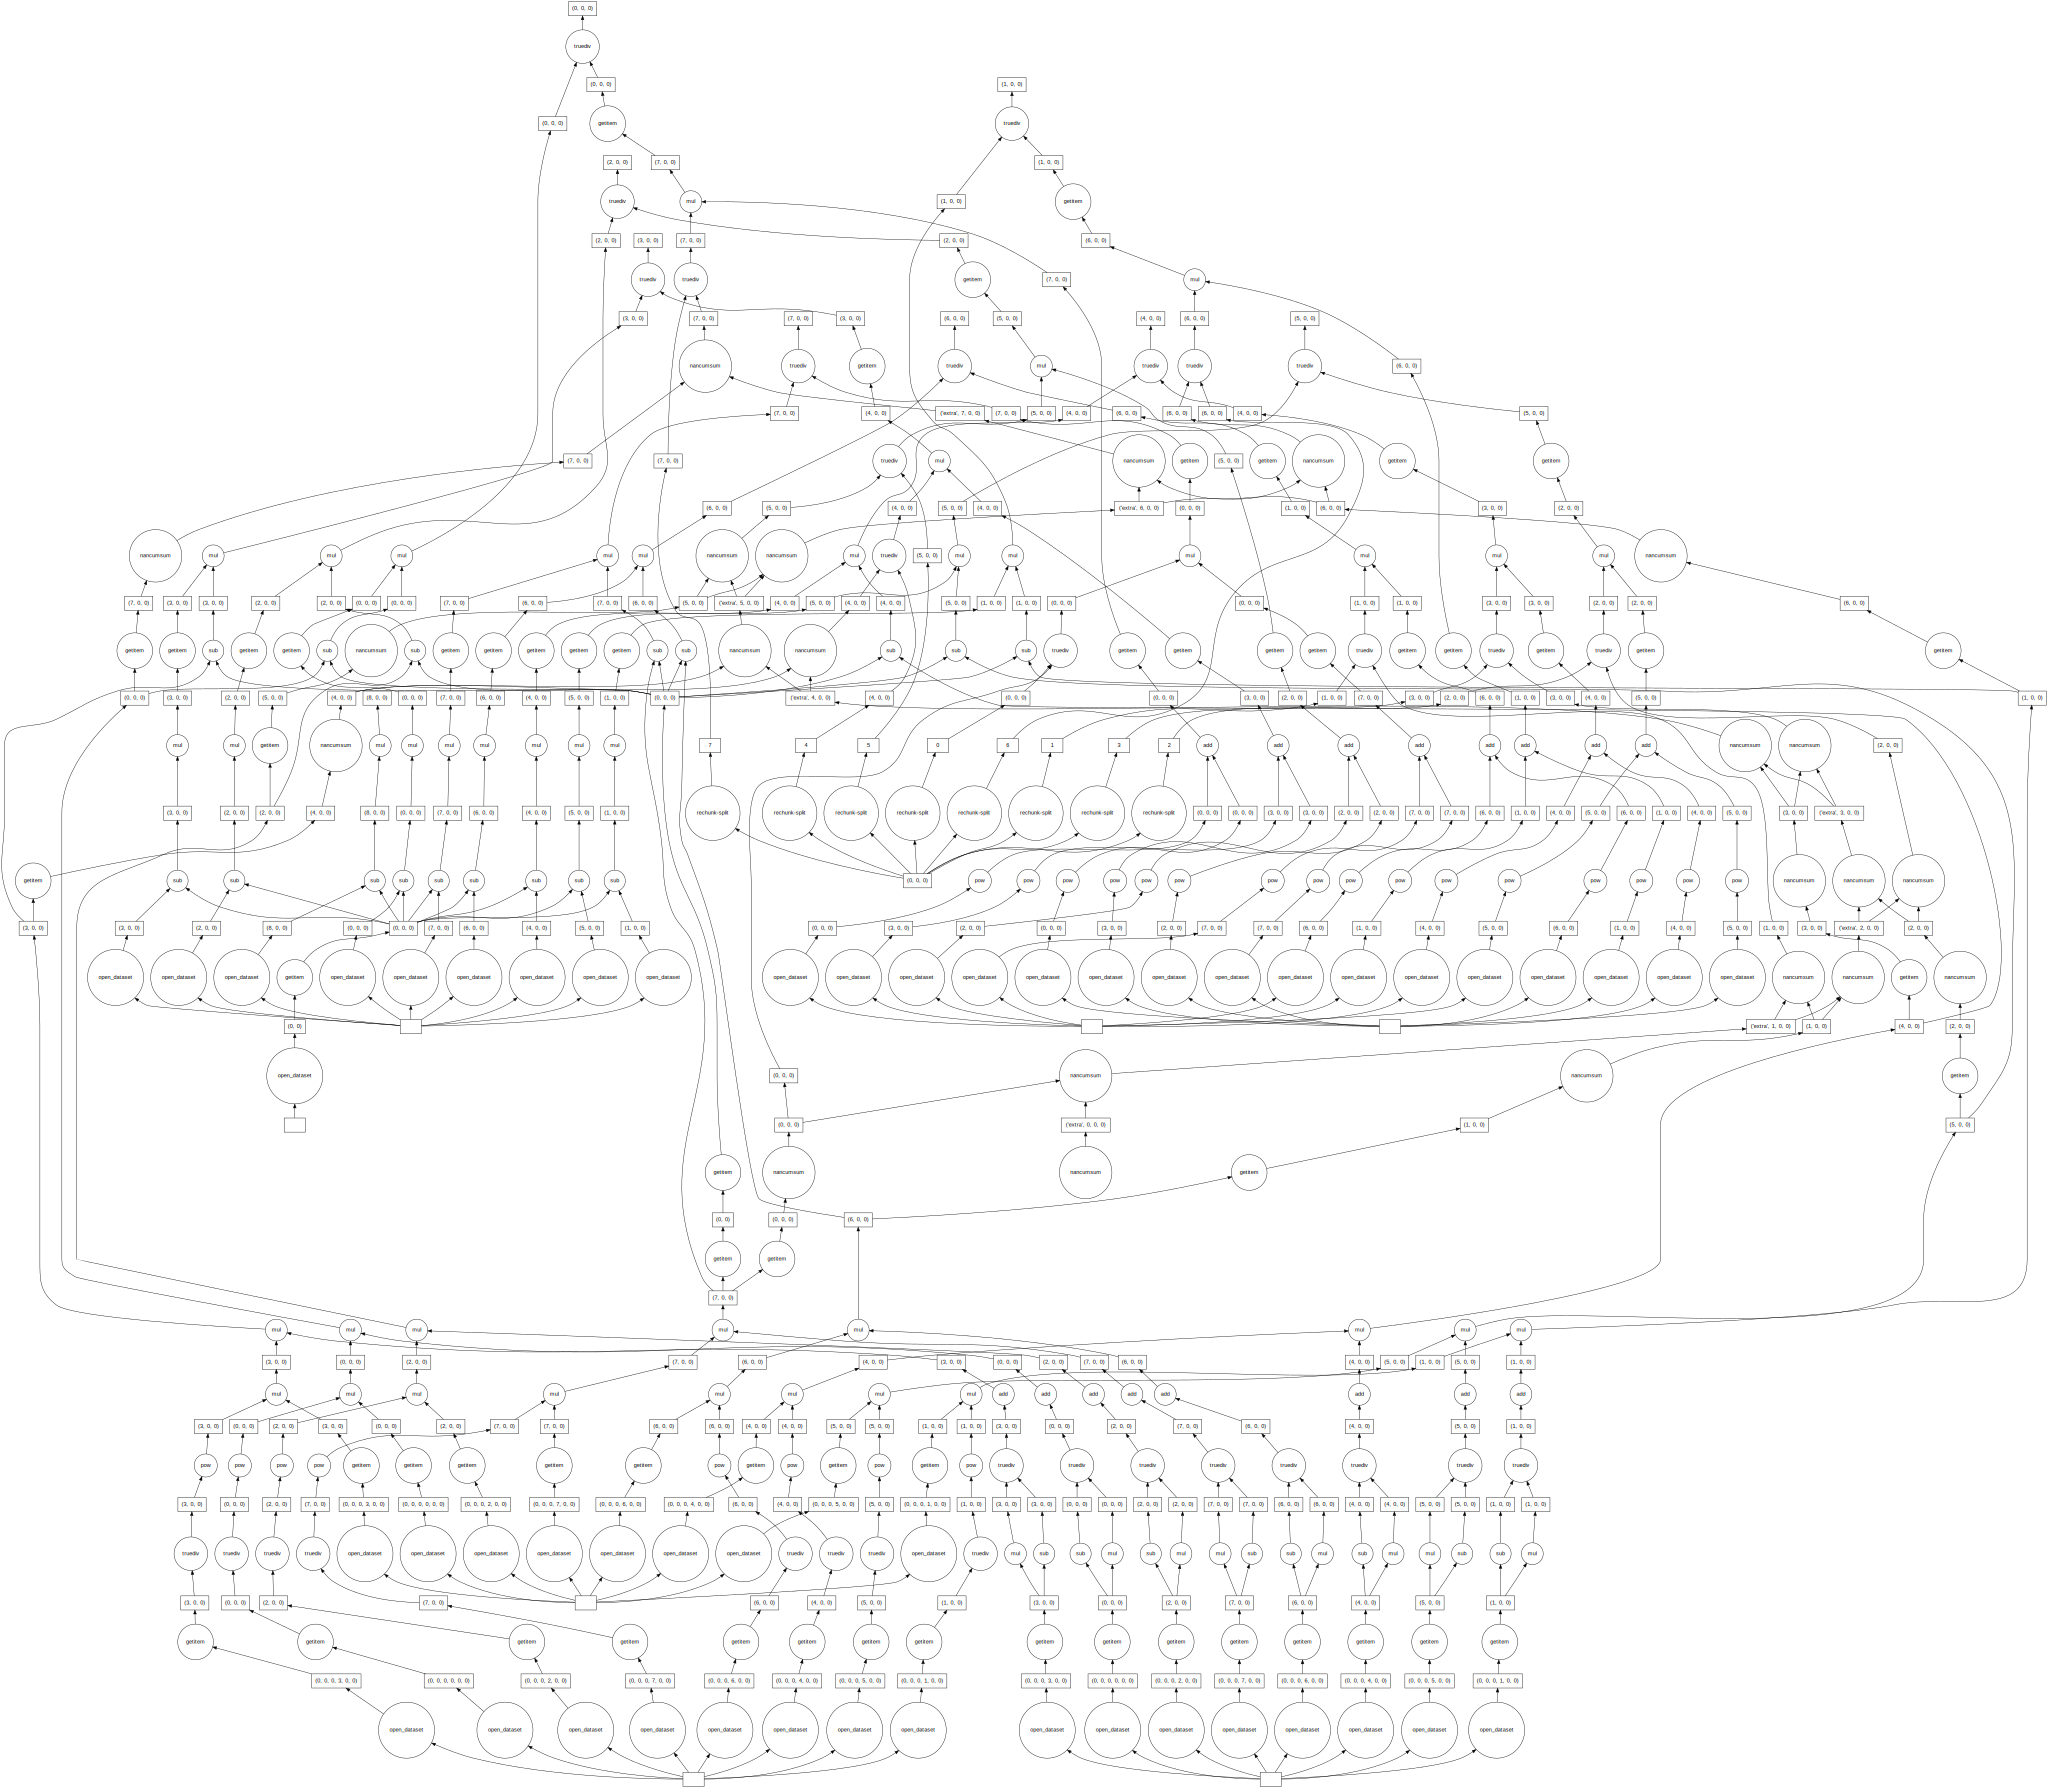

In [237]:
brn.data.visualize(filename='thetav.svg')

# Compute and Store

In [8]:
start=time.time()
brn.compute()
end=time.time()
print("Time:", end-start)

Time: 9.672746658325195


In [9]:
start=time.time()
brn.to_netcdf(path="brn_out.nc")
end=time.time()
print("Time:", end-start)

Time: 6.560786247253418


In [9]:
brn

<xarray.DataArray 'BRN' (generalVerticalLayer: 80, y: 786, x: 1170)>
array([[[ 5.62498568e+00,  5.58283520e+00,  5.56662824e+00, ...,
          8.08694283e+00,  8.05338499e+00,  8.01998957e+00],
        [ 5.65390283e+00,  5.59547880e+00,  5.58109462e+00, ...,
          8.11574342e+00,  8.08141939e+00,  8.04753769e+00],
        [ 5.70246864e+00,  5.61844281e+00,  5.59849780e+00, ...,
          8.15699927e+00,  8.12314932e+00,  8.09084559e+00],
        ...,
        [ 2.04341788e+02,  2.08336806e+02,  2.12171970e+02, ...,
          1.61346427e+01,  1.61654894e+01,  1.62214131e+01],
        [ 1.97226524e+02,  2.01183487e+02,  2.05061044e+02, ...,
          1.61012215e+01,  1.61220736e+01,  1.61798920e+01],
        [ 1.90594335e+02,  1.94562431e+02,  1.98309917e+02, ...,
          1.60731945e+01,  1.60914955e+01,  1.61438843e+01]],

       [[ 1.87543201e+01,  1.84160456e+01,  1.81456440e+01, ...,
          1.83493222e+01,  1.83769085e+01,  1.84041787e+01],
        [ 1.88344896e+01,  1.84492765e+01,  1.82005241e+01, ...,
          1.83501450e+01,  1.83739904e+01,  1.83964875e+01],
        [ 1.88053070e+01,  1.83741351e+01,  1.81270037e+01, ...,
          1.83837568e+01,  1.84066499e+01,  1.84292034e+01],
...
        [-1.77857848e-01, -1.77045065e-01, -1.79599251e-01, ...,
         -3.29189875e-01, -3.24802477e-01, -3.21378116e-01],
        [-1.76326219e-01, -1.77463675e-01, -1.79812988e-01, ...,
         -3.39025383e-01, -3.31536802e-01, -3.25461321e-01],
        [-1.76762169e-01, -1.77827134e-01, -1.80206656e-01, ...,
         -3.43849103e-01, -3.37004056e-01, -3.31169704e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates:
  * generalVerticalLayer  (generalVerticalLayer) float64 1.0 2.0 ... 79.0 80.0
    number                int64 0
    time                  datetime64[ns] 2021-11-02T12:00:00
    step                  timedelta64[ns] 00:00:00
    latitude              (y, x) float64 42.14 42.14 42.14 ... 50.16 50.16 50.16
    longitude             (y, x) float64 0.7593 0.7726 0.786 ... 17.52 17.54
    valid_time            datetime64[ns] 2021-11-02T12:00:00
    surface               float64 ...
Dimensions without coordinates: y, x

In [3]:
%%html
<style>
table {float:left}
</style>

# Fieldextra timing BRN:

| section  | time (s) | 
| --- | --- |
| collect data | 3.654 |
| generate output | 22.292 |

# Dask timing BRN:

In [231]:
import importlib
import perfdata_brn
importlib.reload(perfdata_brn)
display(perfdata_brn.ssync)
display(perfdata_brn.sthreads)
display(perfdata_brn.slocalc)
display(perfdata_brn.sdist)


,chunk,#cores/node,#nodes,time (s),load (s),compute (s),compute & store (s)
0,0,1,1,18.26,6.90,8.77,11.36
1,10,1,1,19.86,8.43,11.22,11.43


,chunk,#cores/node,#nodes,time (s),load (s),compute (s),compute & store (s)
0,10,1,1,21.04,8.57,12.30,12.47
1,10,2,1,15.82,8.52,7.04,7.30
2,10,4,1,14.13,8.68,5.35,5.45
3,10,16,1,13.46,8.40,4.97,5.06


,chunk,#processes,#threads/process,time (s),load (s),compute (s),compute & store (s)
0,10,1,1,25.18,11.58,13.00,13.60
1,10,16,1,15.98,12.58,4.07,3.40
2,10,16,2,15.40,12.40,3.50,3.00


,chunk,#cores/node,#nodes,time (s),load (s),compute (s),compute & store (s)
0,10,2,1,21.20,13.40,8.20,7.80
1,10,2,2,21.50,15.50,7.00,6.00
2,10,2,3,21.50,17.20,4.35,4.30
3,10,2,4,23.05,19.00,4.40,4.05
4,10,4,4,33.60,28.70,3.70,4.90


# Dask timing THETAV:

In [239]:
import importlib
import perfdata, perfdata_chunk4
importlib.reload(perfdata)
importlib.reload(perfdata_chunk4)

from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

display_side_by_side(perfdata.ssync_thetav, perfdata_chunk4.ssync_thetav)
display_side_by_side(perfdata.sthreads_thetav, perfdata_chunk4.sthreads_thetav)
display_side_by_side(perfdata.slocalc_thetav, perfdata_chunk4.slocalc_thetav)
display_side_by_side(perfdata.sdist_thetav, perfdata_chunk4.sdist_thetav)

,chunk,#cores/node,#nodes,load (s),compute & store (s)
0,0,1,1,7.20,6.24
1,10,1,1,8.70,7.30
,chunk,#cores/node,#nodes,load (s),compute & store (s)
0,1,1,1,8.70,6.90


,chunk,#cores/node,#nodes,load (s),compute & store (s)
0,10,1,1,8.67,7.91
1,10,2,1,8.78,4.43
2,10,4,1,8.67,3.27
3,10,16,1,8.56,3.24
,chunk,#cores/node,#nodes,load (s),compute & store (s)
0,10,1,1,8.60,7.43
1,10,2,1,8.90,4.41
2,10,4,1,8.75,2.69
3,10,16,1,8.80,2.70


,chunk,#processes,#threads/process,load (s),compute & store (s)
0,10,1,1,12.60,8.65
1,10,16,1,12.80,1.68
2,10,16,2,12.70,1.07
,chunk,#processes,#threads/process,load (s),compute & store (s)
0,10,1,1,11.90,8.19
1,10,16,1,13.05,1.30
2,10,16,2,12.80,1.05


,chunk,#cores/node,#nodes,load (s),compute & store (s)
0,10,2,1,16.10,4.69
1,10,2,2,19.20,2.71
2,10,2,3,20.00,2.50
3,10,2,4,21.50,2.30
4,10,4,4,29.00,1.82
,chunk,#cores/node,#nodes,load (s),compute & store (s)
0,10,2,1,14.80,4.20
1,10,2,2,17.10,2.58
2,10,2,3,19.00,1.97
3,10,2,4,21.60,1.75
